# Import

In [1]:
import pandas as pd
import numpy as np
import tqdm
from haversine import haversine
import plotly.express as px
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from IPython.display import HTML

In [2]:
from matplotlib import cm
from pygsp import graphs, filters, plotting, utils
import plotly.graph_objects as go

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pickle

## Earthquake

In [5]:
df= pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

In [6]:
df_global= pd.concat([pd.read_csv('00_05.csv'),pd.read_csv('05_10.csv'),pd.read_csv('10_15.csv'),pd.read_csv('15_20.csv')]).iloc[:,[0,1,2,4]].rename(columns={'latitude':'Latitude','longitude':'Longitude','mag':'Magnitude'}).reset_index().iloc[:,1:]

In [7]:
df_global = df_global.assign(Year=list(map(lambda x: x.split('-')[0], df_global.time))).iloc[:,1:]

In [8]:
df_global.Year = df_global.Year.astype(np.float64)

In [9]:
class MooYaHo:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')

In [10]:
class MooYaHo2(MooYaHo): # ebayesthresh 기능추가
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2)))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        self.con = np.where(self.df.Residual>0.7,1,0)

In [11]:
class eachlocation(MooYaHo2):
    def haiti(self,MagThresh=7,ResThresh=1,adjzoom=5,adjmarkersize = 40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=18.4430, lon=-72.5710), 
                        zoom= adjzoom,
                        height=900,
                        opacity = 0.8,
                        mapbox_style="open-street-map",
                        range_color=[-3,3])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.4
                    )
                ))
        return fig 
    def lquique(self,MagThresh=7,ResThresh=1,adjzoom=5, adjmarkersize= 40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=-32.6953, lon=-71.4416), 
                        zoom=adjzoom,
                        height=900,
                        opacity = 0.8,
                        mapbox_style="open-street-map",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.8
                    )
                ))
        return fig 
    def sichuan(self,MagThresh=7,ResThresh=1,adjzoom=5,adjmarkersize=40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=30.3080, lon=102.8880), 
                        zoom=adjzoom,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="open-street-map",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.8
                    )
                ))
        return fig 

In [12]:
each_location=eachlocation(df_global.query("2010 <= Year < 2015"))

`-` get distance 

In [13]:
each_location.get_distance()

100%|██████████| 12498/12498 [03:22<00:00, 61.58it/s] 


In [14]:
each_location.D[each_location.D>0].mean()

8810.865423093777

(array([14176290., 16005894., 21186674., 22331128., 19394182., 17548252.,
        16668048., 13316436., 12973260.,  2582550.]),
 array([8.97930163e-02, 2.00141141e+03, 4.00273303e+03, 6.00405465e+03,
        8.00537626e+03, 1.00066979e+04, 1.20080195e+04, 1.40093411e+04,
        1.60106627e+04, 1.80119844e+04, 2.00133060e+04]),
 <BarContainer object of 10 artists>)

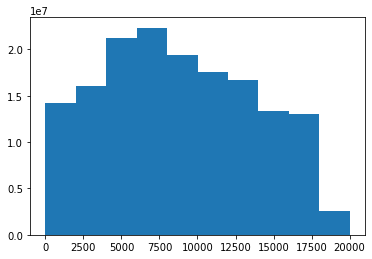

In [15]:
plt.hist(each_location.D[each_location.D>0])

`-` weight matrix

In [16]:
each_location.get_weightmatrix(theta=(8810.865423093777),kappa=2500) 

`-` fit

In [17]:
each_location.fit2()

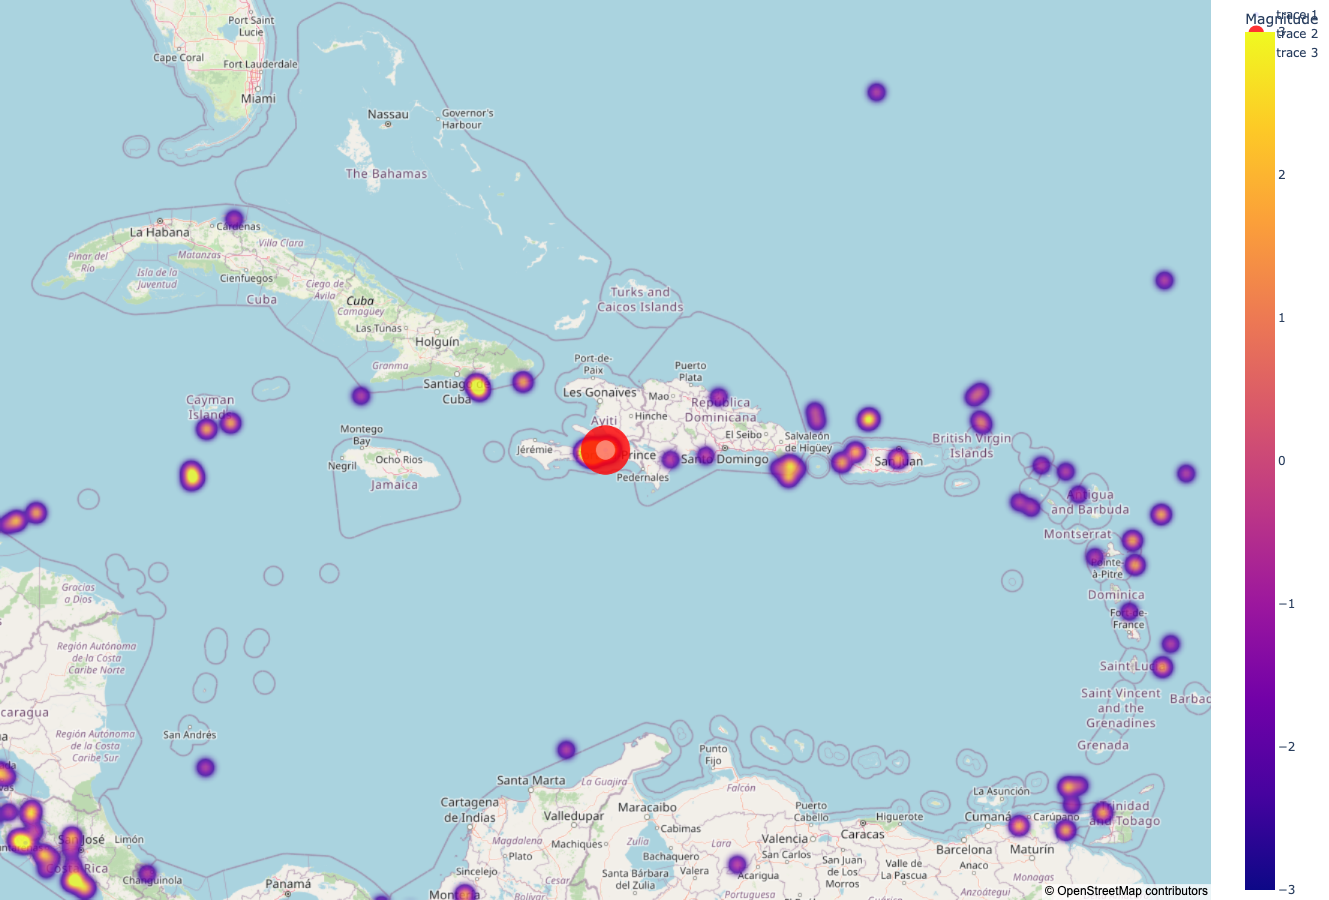

In [28]:
each_location.haiti(MagThresh=6.9,ResThresh=0.5,adjzoom=5,adjmarkersize=40)
fig = each_location.haiti(MagThresh=6.9,ResThresh=0.5,adjzoom=5,adjmarkersize=50)
with open('earth_haiti.pkl', 'wb') as file:
    pickle.dump(fig, file)

with open('earth_haiti.pkl', 'rb') as file:
    earth_haiti = pickle.load(file)
earth_haiti.show()

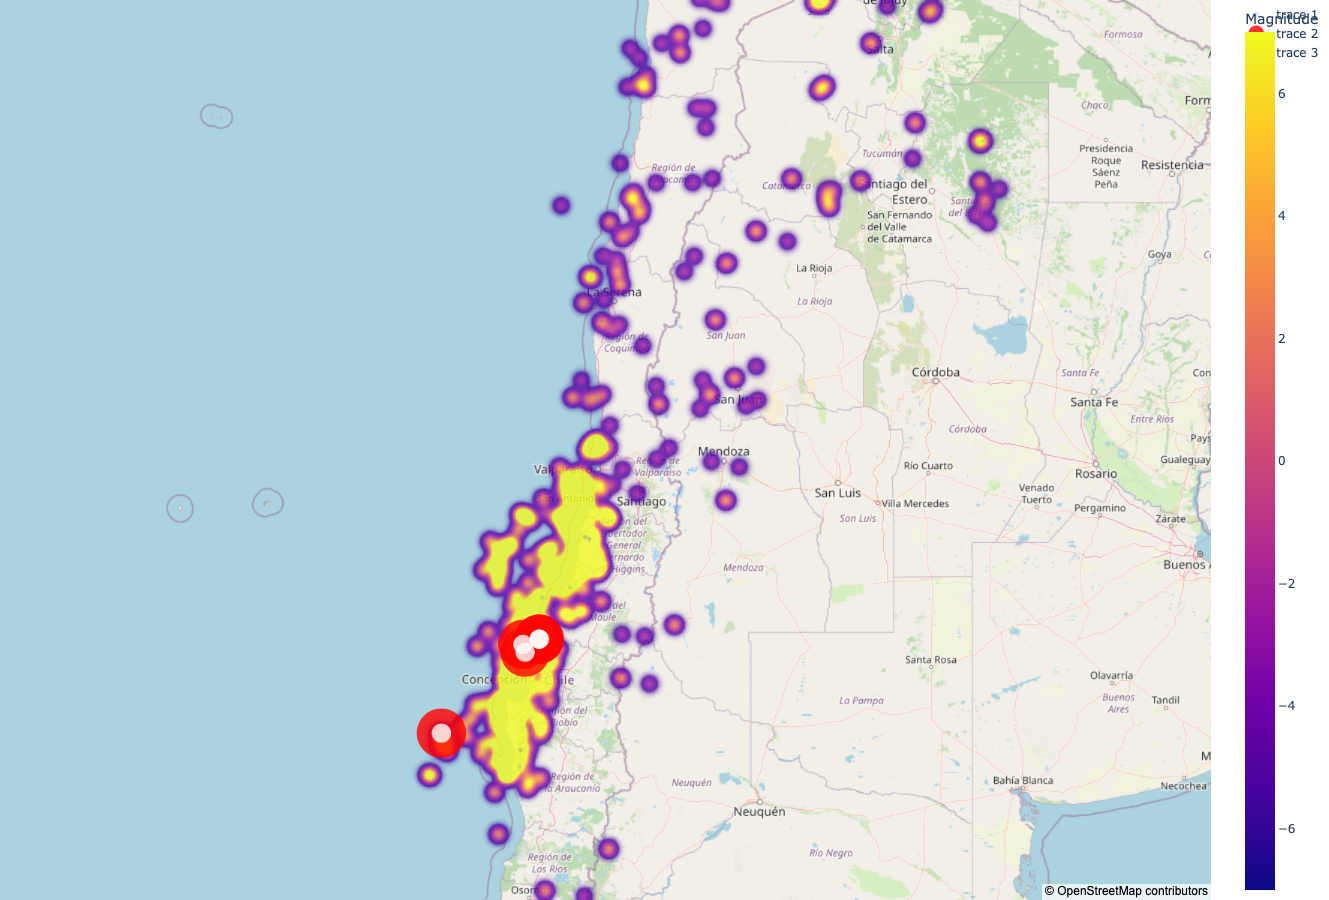

In [29]:
each_location.lquique(MagThresh=6.4,ResThresh=0.4,adjzoom=5,adjmarkersize=40)
fig = each_location.lquique(MagThresh=6.4,ResThresh=0.4,adjzoom=5,adjmarkersize=50)

with open('earth_lquique.pkl', 'wb') as file:
    pickle.dump(fig, file)

with open('earth_lquique.pkl', 'rb') as file:
    earth_lquique = pickle.load(file)
earth_lquique.show()

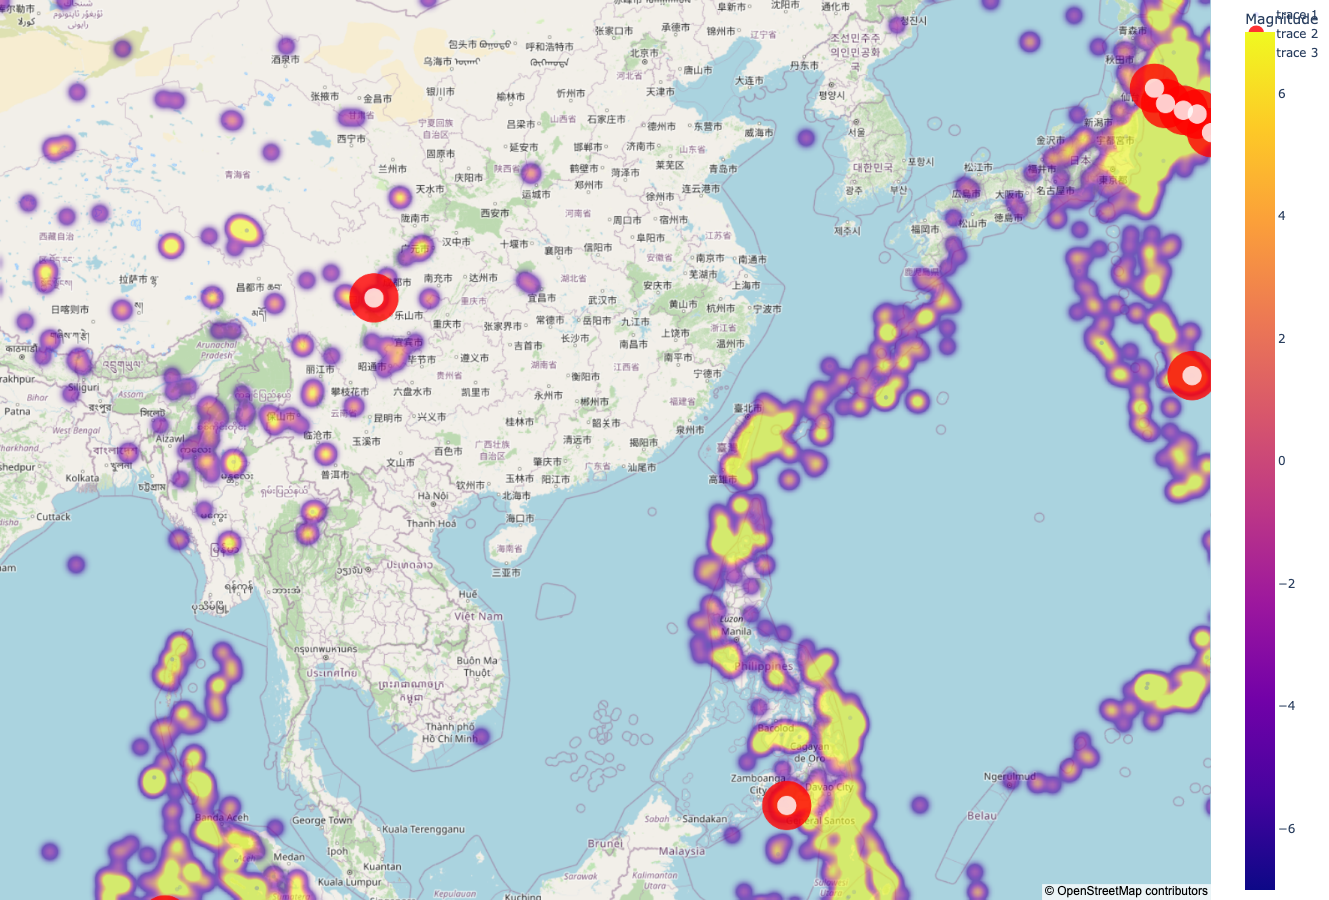

In [30]:
each_location.sichuan(MagThresh=6.5,ResThresh=0.4,adjzoom=5,adjmarkersize=40)
fig = each_location.sichuan(MagThresh=6.5,ResThresh=0.4,adjzoom=5,adjmarkersize=50)
with open('earth_sichuan.pkl', 'wb') as file:
    pickle.dump(fig, file)

with open('earth_sichuan.pkl', 'rb') as file:
    earth_sichuan = pickle.load(file)
earth_sichuan.show()